In [ ]:
"""
    Denoising photoplethysmogram (PPG) data using autoencoder model with ANN, RNN, or BiRNN

    1) data loading using a 40Hz 10sec PPG dataset extracted from various sources
    - during data loading, noises can be added to the data to train the denoising model

    2) definitions of models: ANN, RNN, BiRNN

    3) compiling the denoising autoencoder model based on (2), training, and validation

    Tensorflow-Keras 2.3.0

    Author: Joonnyong Lee, PhD (CEO, Mellowing Factory Co., Ltd.)
    Date: 2020-8-31
"""

In [11]:
"""Create a folder called '20200917_KOHI_RNN_DAE-master' in your Google Drive and upload this file and the unzipped PPG data file"""

""" 런타임 > 런타임 유형 변경 (GPU) """
""" Install """
# !pip install tensorflow-gpu

# load the required libraries
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/gdrive')

# which deep learning model to use
model_choice = 'RNN'  # 'RNN' or 'BiRNN'

# model parameters
timesteps = 60
sampling_frequency = 40
hidden_layer_units = 10

# create checkpoint path for the model
if model_choice == 'ANN':
    FILEWRITER_PATH = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_ANN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard'
    if not os.path.isdir(FILEWRITER_PATH):
        os.makedirs(FILEWRITER_PATH)
    CHECKPOINT_PATH = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_ANN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard/checkpoints'
    if not os.path.isdir(CHECKPOINT_PATH):
        os.makedirs(CHECKPOINT_PATH)
elif model_choice == 'RNN':
    FILEWRITER_PATH = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_RNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard'
    if not os.path.isdir(FILEWRITER_PATH):
        os.makedirs(FILEWRITER_PATH)
    CHECKPOINT_PATH = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_RNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard/checkpoints'
    if not os.path.isdir(CHECKPOINT_PATH):
        os.makedirs(CHECKPOINT_PATH)
elif model_choice == 'BiRNN':
    FILEWRITER_PATH = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_BiRNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard'
    if not os.path.isdir(FILEWRITER_PATH):
        os.makedirs(FILEWRITER_PATH)
    CHECKPOINT_PATH = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_BiRNN_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_tensorboard/checkpoints'
    if not os.path.isdir(CHECKPOINT_PATH):
        os.makedirs(CHECKPOINT_PATH)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_40Hz_10sec_25000set.txt
The shape of the original dataset is 25000 by 400
The shape of the 60 timestep dataset is 150000 by 60


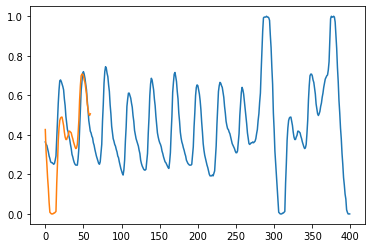

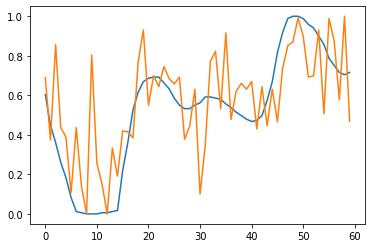

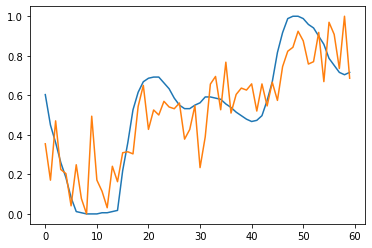

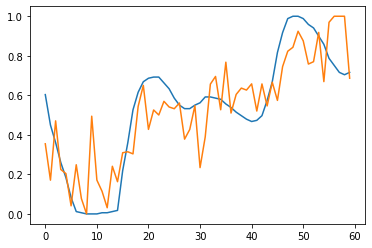

(120000, 60, 1)
(120000, 60)


In [12]:
# -------------------------------------------- load data & pre-processing -------------------------------------------- #

# set this to the path of your data file
PPG_data_path = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_40Hz_10sec_25000set.txt'
print(PPG_data_path)

def signal_extraction(data_path):

    # load the dataset
    # the [0] index is there because there is one file in this dataset, if there are more than file for the dataset, do a for-loop to load each data file
    PPG_data = np.loadtxt(data_path)
    print('The shape of the original dataset is %i by %i' % np.shape(PPG_data))  # (10000, 400) -> 10000 rows of 40Hz 10sec PPG data
    print('The shape of the %i timestep dataset is %i by %i' % (timesteps, int(np.ceil((400-timesteps)/timesteps)*len(PPG_data)), timesteps))

    # shuffle the data
    shuffle(PPG_data)

    # create empty lists to hold training and validation datasets
    train_input_data_list = []
    train_output_data_list = []
    val_input_data_list = []
    val_output_data_list = []

    # loop through the original dataset and perform data extraction/noise addition on each row
    for datanum in range(len(PPG_data)):
        # separate the PPG segment in each row into timestep size
        for index in range(0, 400-timesteps, timesteps):

            # ---------- original data, normalized ----------
            a = PPG_data[datanum, index:index + timesteps].copy()
            a = a - np.min(a)
            a = a / np.max(a)
            # plt.figure()
            # plt.plot(a)

            # ---------- Gaussian noise data ----------
            noise1 = np.random.randn(len(a))*1/3
            b = a.copy() + noise1
            b = b - np.min(b)
            b = b / np.max(b)
            # plt.plot(b-1)
            # plt.show()

            # ---------- Gaussian noise + low freq noise data ----------
            c = b.copy()
            slope = np.random.randn()
            for i in range(len(c)):
                c[i] = c[i] + slope/len(c)*i
            # slope_vector = np.linspace()
            # c = c + slope_vector
            c = c - np.min(c)
            c = c / np.max(c)

            # ---------- Gaussian noise + low freq noise + saturation data ----------
            d = c.copy()
            location1 = np.random.randint(timesteps)
            location2 = location1 + np.random.randint(timesteps-location1)
            if np.random.randn() > 0:
              d[location1:location2] = np.zeros(location2-location1, float)
            else:
              d[location1:location2] = np.ones(location2-location1, float)
            

            # put 80% of the data into the training dataset list, and 20% into the validation dataset list
            if datanum < 0.8 * len(PPG_data):
                train_input_data_list.append(a)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
                train_output_data_list.append(a)
            else:
                val_input_data_list.append(a)  # CHANGE THIS TO THE NOISE-AUGMENTED DATA
                val_output_data_list.append(a)

    # plot the last data
    plt.figure()
    plt.plot(PPG_data[datanum])
    plt.plot(PPG_data[datanum,index:index + timesteps])
    plt.show()
    plt.figure()
    plt.plot(a)
    plt.plot(b)
    plt.show()
    plt.figure()
    plt.plot(a)
    plt.plot(c)
    plt.show()
    plt.figure()
    plt.plot(a)
    plt.plot(d)
    plt.show()

    # convert the dataset lists into arrays
    train_input_data_list = np.asarray(train_input_data_list)
    train_output_data_list = np.asarray(train_output_data_list)
    val_input_data_list = np.asarray(val_input_data_list)
    val_output_data_list = np.asarray(val_output_data_list)

    return train_input_data_list, train_output_data_list, val_input_data_list, val_output_data_list


[train_input_data_list, train_answer_data_list, val_input_data_list, val_answer_data_list] = signal_extraction(PPG_data_path)

# if the deep learning model used here is recurrent, need to reshape the input data to match the keras LSTM input_shape
if model_choice == 'RNN' or model_choice == 'BiRNN':
    train_input_data_list = np.reshape(train_input_data_list, [len(train_input_data_list), timesteps, 1])
    val_input_data_list = np.reshape(val_input_data_list, [len(val_input_data_list), timesteps, 1])

print(np.shape(train_input_data_list))
print(np.shape(train_answer_data_list))

In [13]:
# ------------------------------------------ deep learning model definition ------------------------------------------ #

def ANN():

    model_inputs = tf.keras.Input(shape=(timesteps, ))
    encoding_layer = tf.keras.layers.Dense(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps,))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model


def RNN():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model


def BiRNN():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_layer_units, activation='sigmoid', input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model


def BiRNN_MM():

    model_inputs = tf.keras.Input(shape=(timesteps, 1))
    encoding_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_layer_units, return_sequences=True, activation='sigmoid', input_shape=(timesteps, 1)))(model_inputs)
    out_layer = tf.keras.layers.Dense(units=timesteps, activation='sigmoid')(encoding_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=out_layer)

    return model

print('Setting model complete')

Setting model complete


In [ ]:
# ----------------------------------- deep learning model training & validation -------------------------------------- #

if model_choice == 'ANN':
    DAE = ANN()
elif model_choice == 'RNN':
    DAE = RNN()
elif model_choice == 'BiRNN':
    DAE = BiRNN()

# compile the model with optimizer and loss function
# opt = tf.keras.optimizers.Adam(learning_rate=1)
DAE.compile(optimizer='adam', loss='mse')
cp_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, verbose=1, save_best_only=True, save_weights_only=True, period=1)

# train the model
DAE.fit(train_input_data_list, train_answer_data_list, epochs=10000, batch_size=40000, shuffle=True, validation_data=(val_input_data_list, val_answer_data_list), verbose=2, callbacks=[cp_callback])

# load the trained model
DAE.load_weights(CHECKPOINT_PATH)

# generate predictions (inferences) based on validation input data
prediction = DAE.predict(val_input_data_list)

# reshape the validation input data, prediction, and the answer for saving purposes
prediction = np.reshape(prediction, [-1])
val_input_data_list = np.reshape(val_input_data_list, [-1])
val_answer_data_list = np.reshape(val_answer_data_list, [-1])

# save 10% of the validation results for further analyses
name = '/content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_' + model_choice + '_' + str(timesteps) + 'timesteps_' + str(hidden_layer_units) + 'nodes_prediction_results.txt'
file = open(name, 'w')
for result_num in range(int(len(prediction)/10)):
    file.write("%f %f %f \n" % (val_input_data_list[result_num], prediction[result_num], val_answer_data_list[result_num]))
file.close()

plt.figure()
plt.plot(val_input_data_list[0:timesteps])
plt.plot(prediction[0:timesteps])
plt.plot(val_answer_data_list[0:timesteps])
plt.show()

Epoch 1/10000

Epoch 00001: val_loss improved from inf to 0.12543, saving model to /content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_RNN_60timesteps_10nodes_tensorboard/checkpoints
3/3 - 0s - loss: 0.1256 - val_loss: 0.1254
Epoch 2/10000

Epoch 00002: val_loss improved from 0.12543 to 0.12431, saving model to /content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_RNN_60timesteps_10nodes_tensorboard/checkpoints
3/3 - 0s - loss: 0.1245 - val_loss: 0.1243
Epoch 3/10000

Epoch 00003: val_loss improved from 0.12431 to 0.12321, saving model to /content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_RNN_60timesteps_10nodes_tensorboard/checkpoints
3/3 - 0s - loss: 0.1234 - val_loss: 0.1232
Epoch 4/10000

Epoch 00004: val_loss improved from 0.12321 to 0.12213, saving model to /content/gdrive/My Drive/20200917_KOHI_RNN_DAE-master/PPG_DAE_RNN_60timesteps_10nodes_tensorboard/checkpoints
3/3 - 0s - loss: 0.1223 - val_loss: 0.1221
Epoch 5/10000

Epoch 00005: val_loss improve